# 1. Import

In [169]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

from pathlib import Path
from tqdm import tqdm
import datetime

# 2. Load Data

In [170]:
# load daily industry returns
df_daily = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios_Daily.CSV", index_col = 0)
df_daily.index = pd.to_datetime(df_daily.index, format = "%Y%m%d")
df_daily = df_daily / 100

# handle NA values
mask = (df_daily <= -0.99)
df_daily[mask] = np.nan

In [171]:
# load Fama French 3 Daily Factors
ff = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors_daily.CSV", index_col = 0)
ff.index = pd.to_datetime(ff.index, format = "%Y%m%d")
ff = ff / 100

# load Fama French 3 Monthly Factors
ff_monthly = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff_monthly.index = pd.to_datetime(ff_monthly.index, format = "%Y%m")
ff_monthly = ff_monthly / 100


# load 4 Monthly Fama French Factors (Mkt-RF, SMB, HML, MOM) and construct FF4 model
ff4 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff4.index = pd.to_datetime(ff4.index, format = "%Y%m")
ff4 = ff4 / 100

ff4_mom = pd.read_csv(str(Path().absolute()) + "/data/F-F_Momentum_Factor.CSV", index_col = 0)
ff4_mom.index = pd.to_datetime(ff4_mom.index, format = "%Y%m")
ff4_mom = ff4_mom / 100
ff4 = pd.concat([ff4, ff4_mom], axis = 1)
ff4 = ff4.dropna()


# load Fama French 5 Daily Factors
ff5 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_5_Factors_2x3.csv", index_col = 0)
ff5.index = pd.to_datetime(ff5.index, format = "%Y%m")
ff5 = ff5 / 100

In [192]:
# load 4 dataframes (returns, nb industries, avg firm size, Sum of BE / Sum of ME)
df = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV") 

# split these dataframes
df_list = np.split(df, df[df.isnull().all(1)].index, axis = 0) 

# clean data and convert date column to index
for i in range(len(df_list)):
    df_list[i] = pd.DataFrame(df_list[i])  
    df_list[i] = df_list[i].dropna()  
    df_list[i].loc[:, "Date"] = df_list[i].loc[:, "Date"].astype("int")  
    df_list[i] = df_list[i].set_index("Date")  
    
    # last data frame has yearly data
    if i == (len(df_list) - 1): 
        df_list[i].index = pd.to_datetime(df_list[i].index, format = "%Y")
        df_list[i].index = df_list[i].index + pd.DateOffset(months = 6)
    else:
        df_list[i].index = pd.to_datetime(df_list[i].index, format = "%Y%m")

# create a dataframe of excess returns, nb of industries and avg sizes
df = df_list[0] / 100
mask = (df <= -0.99)
df[mask] = np.nan

nb_industries = df_list[1]
nb_industries[mask] = np.nan

avg_size = df_list[2]
avg_size[mask] = np.nan

be_over_me = df_list[3]
be_over_me[mask] = np.nan


/var/folders/cb/4hmkv_ks12v6rtbh4ht9tzbr0000gp/T/ipykernel_17482/3744216038.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_list[i].loc[:, "Date"] = df_list[i].loc[:, "Date"].astype("int")
/var/folders/cb/4hmkv_ks12v6rtbh4ht9tzbr0000gp/T/ipykernel_17482/3744216038.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_list[i].loc[:, "Date"] = df_list[i].loc[:, "Date"].astype("int")
/var/folders/cb/4hmkv_ks12v6rtbh4ht9tzbr0000gp/T/ipykernel_17482/3744216038.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

# 3. Calculate Characteristics

## 3.1 Market Cap, Book-to-Market, Momentum

In [193]:
# market cap of each industry over time
mkt_cap = nb_industries * avg_size

# book value to market value
# resample be_over_me to monthly data
# we must first shift years since our "factor year" begins in July preventing us from grouping by years
# can't just resample and ffill since there are years with NAs in 
# the middle of the dataset which would be erroneously filled (eg: Rubber in 1943)
be_over_me.index = be_over_me.index - pd.DateOffset(months = 6)
be_over_me = be_over_me.resample("MS").asfreq()
be_over_me.loc[:, "Year"] = be_over_me.index.year
be_over_me = be_over_me.groupby("Year").transform(lambda x: x.ffill())
be_over_me.index = be_over_me.index + pd.DateOffset(months = 6)  # unshift back to "factor yeear" starting in July

# need to add missing portion of 2024
extra_be_over_me = pd.DataFrame(np.repeat([be_over_me.iloc[-1].values], repeats = 5, axis = 0), 
                                index = pd.date_range(start=be_over_me.index[-1] + pd.DateOffset(months = 1), end='2024-12-01', freq='MS'), 
                                columns = be_over_me.columns)

be_over_me = pd.concat([be_over_me, extra_be_over_me], axis = 0)

# momentum with monthly data
momentum = df.rolling(12).mean()

## 3.2 Beta

In [106]:
indices = pd.date_range("1926-06-30", "2024-12-31", freq = "M")
betas = pd.DataFrame(index=indices, columns=df_daily.columns)

for industry, industry_timeseries in tqdm(df_daily.items()):
    # skip first 12 months since we need a 12 month lookback window
    for i in range(12, len(indices)):
        
        # start and end date
        # this ensures ranges of following form for example: Sep 1 to Aug 31 
        start = indices[i-12] + pd.Timedelta(days = 1)
        end = indices[i]
        
        X = ff.loc[start:end,["Mkt-RF"]]
        y = industry_timeseries.loc[start:end] - ff.loc[start:end, "RF"]
        
        try:
            beta = LinearRegression(fit_intercept=True).fit(X, y).coef_[0]
        except ValueError:
            beta = np.nan
        
        betas.loc[end, industry] = beta
    
# convert theindices from month ends to starts of months
betas = betas.resample("MS").last()

48it [00:34,  1.37it/s]


## 3.3 Idiosyncratic Risk

In [122]:
# Get unique year-month pairs
monthly_periods = df_daily.resample('MS').mean().index

risk = pd.DataFrame(index=monthly_periods, columns=df_daily.columns)

for date in tqdm(monthly_periods):
    # Filter data for the entire month
    mask = (df_daily.index.year == date.year) & (df_daily.index.month == date.month)
    ret_data = df_daily[mask]
    factors_data = ff[mask]
    
    for industry, industry_timeseries in ret_data.items():
            
            # Ensure aligned data
            aligned_data = pd.concat([industry_timeseries, factors_data], axis = 1)
            
            X = aligned_data.loc[:,["Mkt-RF", "SMB", "HML"]].values
            y = (aligned_data.loc[:, industry] - aligned_data.loc[:, "RF"]).values
            
            try:
                reg = LinearRegression(fit_intercept=True).fit(X, y)
                resid = y - reg.predict(X)
            except ValueError:
                resid = np.nan
            risk.loc[date, industry] = np.std(resid)
            

100%|███████████████████████████████████████| 1182/1182 [00:35<00:00, 33.75it/s]


## 3.4 Long-Short Portfolios

In [195]:
def position(df, n_assets):
    
    ranks = df.rank(axis = 1)
    df_pos = pd.DataFrame(0, index = ranks.index, columns = ranks.columns)
    
    # longs
    df_pos[ranks <= n_assets] = 1
    
    # shorts
    threshold = (ranks.max(axis = 1) - n_assets)
    mask = ranks.gt(threshold, axis = 0)
    df_pos[mask] = -1
    
    return df_pos

In [196]:
def equal_weight_rets(df, position, n_longs):
    
    performance = ((df * position) / n_longs).sum(axis = 1)
    return performance


def value_weights_rets(df, position, mkt_cap):
    
    # long and short market weighted weights
    long_weights = mkt_cap[position == 1].div(mkt_cap[position == 1].sum(axis = 1), axis = 0)
    short_weights = mkt_cap[position == -1].div(mkt_cap[position == -1].sum(axis = 1), axis = 0)
    
    # returns of long-short portfolio
    long_portfolio = (df * long_weights).fillna(0)
    short_portfolio = (df * short_weights).fillna(0)
    performance = (long_portfolio + short_portfolio).sum(axis = 1)
    
    return performance

In [197]:
# long-short portfolio positions
pos_mkt_cap = position(mkt_cap, 5)
pos_be_over_me = position(be_over_me, 5)
pos_mom = position(momentum, 5)
pos_betas = position(betas, 5)
pos_risks = position(risk, 5)

# 4. Annualized Performance Measures

In [240]:
def mean_return(rets):
    avg_ret = 12 * rets.mean()

    return avg_ret


def sharpe_ratio(rets, rf):
    sharpe = np.sqrt(12) * (rets - rf).mean() / rets.std()  # use excess returns
    return sharpe


def alpha(rets, ff):
    
    reg = LinearRegression(fit_intercept=True).fit(ff, rets)
    
    return 12 * reg.intercept_

In [220]:
# equal weight returns
rets_mkt = equal_weight_rets(df, pos_mkt_cap, 5)
rets_be_me = equal_weight_rets(df, pos_be_over_me, 5)
rets_mom = equal_weight_rets(df, pos_mom, 5)
rets_betas = equal_weight_rets(df, pos_betas, 5)
rets_risks = equal_weight_rets(df, pos_risks, 5)

equal_weight_results = pd.DataFrame({"EW_Mkt": rets_mkt, 
                                     "EW_BE_ME": rets_be_me, 
                                     "EW_Momentum": rets_mom, 
                                     "EW_Beta": rets_betas, 
                                     "EW_Risks": rets_risks}, 
                                     index = rets_mkt.index)

# value weighted returns
rets_mkt = value_weights_rets(df, pos_mkt_cap, mkt_cap)
rets_be_me = value_weights_rets(df, pos_be_over_me, mkt_cap)
rets_mom = value_weights_rets(df, pos_mom, mkt_cap)
rets_betas = value_weights_rets(df, pos_betas, mkt_cap)
rets_risks = value_weights_rets(df, pos_risks, mkt_cap)

value_weights_results = pd.DataFrame({"Val_Mkt": rets_mkt, 
                                      "Val_BE_ME": rets_be_me, 
                                      "Val_Momentum": rets_mom, 
                                      "Val_Beta": rets_betas, 
                                      "Val_Risks": rets_risks}, 
                                      index = rets_mkt.index)

portfolio_results = pd.concat([equal_weight_results, value_weights_results], axis = 1)

In [242]:
start_year = [1950, 1990, 2000]
results = [np.nan, np.nan, np.nan]

for i in range(len(start_year)):
    
    start = start_year[i]
    # select current period for returns
    mask = portfolio_results.index.year >= start
    current_portfolio = portfolio_results[mask]
    
    # select current period for alpha
    current_ff3 = ff_monthly.loc[ff_monthly.index.year >= start, ["Mkt-RF", "SMB", "HML"]]
    current_ff4 = ff4.loc[ff4.index.year >= start, ["Mkt-RF", "SMB", "HML", "Mom   "]]
    current_ff5 = ff5.loc[ff5.index.year >= max(start, 1964), ["Mkt-RF", "SMB", "RMW", "CMA"]]
    
    mean_rets= current_portfolio.apply(mean_return, axis = 0)
    sharpe_ratios = current_portfolio.apply(lambda x: sharpe_ratio(x, ff["RF"]), axis = 0)
    alpha_ff3 = current_portfolio.apply(lambda x: alpha(x, current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)
    alpha_ff4 = current_portfolio.apply(lambda x: alpha(x, current_ff4[["Mkt-RF", "SMB", "HML", "Mom   "]]), axis = 0)
    alpha_ff5 = current_portfolio.loc[current_portfolio.index.year >= 1964].apply(lambda x: alpha(x, current_ff5[["Mkt-RF", "SMB", "RMW", "CMA"]]), axis = 0)
    
    results[i] = pd.concat([mean_rets, sharpe_ratios, alpha_ff3, alpha_ff4, alpha_ff5], axis = 1)
    results[i].columns = ["Mean Return", "Sharpe Ratio", "Alpha 3 Factor Fama French", "Alpha 4 Factor Fama French", "Alpha 5 Factor Fama French"]
    

<Axes: xlabel='Date'>

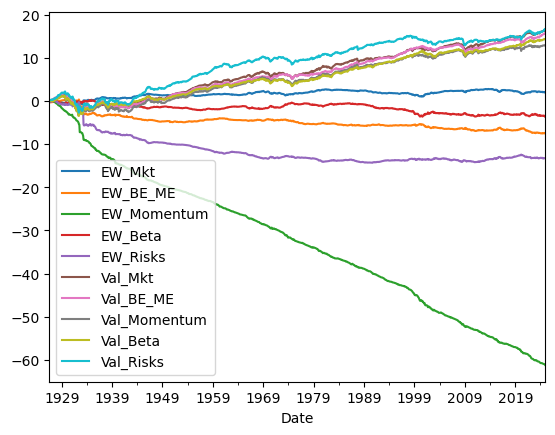

In [212]:
np.log((1 + portfolio_results).cumprod()).plot()

In [244]:
# 1950 + (except for FF5 it is 1964 +)
results[0]

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,Alpha 5 Factor Fama French
EW_Mkt,0.020501,0.174370,-0.016035,-0.001787,-0.051039
EW_BE_ME,-0.024654,-0.050593,0.028848,0.000535,0.025417
EW_Momentum,-0.520146,-2.913605,-0.540148,-0.444295,-0.552191
EW_Beta,-0.009117,-0.130319,0.042896,0.028469,-0.009303
EW_Risks,-0.031156,-0.187743,-0.012039,-0.018870,0.017453
Val_Mkt,0.261261,0.905463,0.083580,0.090767,0.075704
Val_BE_ME,0.253399,0.845950,0.076111,0.085557,0.084165
Val_Momentum,0.235368,0.712679,0.053118,0.052910,0.048425
Val_Beta,0.234306,0.831820,0.075298,0.084864,0.094171
Val_Risks,0.248285,0.745897,0.071690,0.082446,0.050778


In [245]:
results[1] # 1990 +

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,Alpha 5 Factor Fama French
EW_Mkt,0.010408,0.256368,-0.011272,0.005900,-0.061430
EW_BE_ME,-0.035182,-0.420294,0.006439,-0.015406,0.036540
EW_Momentum,-0.580944,-2.774035,-0.611210,-0.535363,-0.610137
EW_Beta,-0.042024,-0.207131,0.037542,0.020030,-0.017603
EW_Risks,0.046848,0.278625,0.062254,0.052110,0.071929
Val_Mkt,0.243303,0.985750,0.059935,0.070361,0.037794
Val_BE_ME,0.238372,0.932259,0.058704,0.069926,0.041350
Val_Momentum,0.199204,0.748295,0.009415,0.012579,-0.008494
Val_Beta,0.233155,0.913476,0.060487,0.069666,0.065642
Val_Risks,0.185835,0.627752,-0.005474,0.010567,-0.022493


In [246]:
results[2] # 2000 +

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,Alpha 5 Factor Fama French
EW_Mkt,0.054878,0.503947,0.023796,0.033804,-0.038845
EW_BE_ME,-0.061761,-0.578308,-0.013942,-0.027938,0.027983
EW_Momentum,-0.571831,-2.579695,-0.604732,-0.556879,-0.591501
EW_Beta,0.025752,-0.004116,0.103017,0.085944,0.046905
EW_Risks,0.026220,0.180433,0.048328,0.045223,0.066785
Val_Mkt,0.223539,0.910189,0.066055,0.073517,0.034949
Val_BE_ME,0.192455,0.778355,0.037474,0.046559,0.016446
Val_Momentum,0.163911,0.654442,0.000001,0.000036,-0.020399
Val_Beta,0.186718,0.796541,0.040092,0.048070,0.046758
Val_Risks,0.189419,0.661050,0.022336,0.027037,0.002538
